In [1]:
import os
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('TensorFlow', tf.__version__)

TensorFlow 1.13.1


In [2]:
train_ids = {i:glob(f'signature_dataset/SIG-DS-II/{x}')[0] for i,x in enumerate(os.listdir('signature_dataset/SIG-DS-II/'))}
train_image_counts = [len(os.listdir(train_ids[x])) for x in range(len(train_ids))]
train_images = {ids:glob(x+'/*') for ids, x in train_ids.items()}

## Some utility functions to preprocess images and make training examples

In [3]:
def get_image(image_path, h=180, w=480):
    '''returns image, pixels scaled [0-1]'''
    img = np.array(tf.keras.preprocessing.image.load_img(image_path, target_size=(h, w), color_mode='grayscale'), dtype=np.float32)[:,:,None]
    img /= 255.
    return img

def make_example(positive=None):
    '''return pairs of images, similar if positive=True'''
    left = None
    y = None
    right = np.random.randint(low=0, high=len(train_ids))
    if positive:
        y = 1
        left = right
    else:
        y = 0
        while True:
            left = np.random.randint(low=0, high=len(train_ids))
            if right != left:
                break
    right_image_idx = np.random.randint(low=0, high=train_image_counts[right])
    left_image_idx = np.random.randint(low=0, high=train_image_counts[left])
    right_image = get_image(train_images[right][right_image_idx])
    left_image = get_image(train_images[left][left_image_idx])
    
    return right_image, left_image, y

## Data generator to read files and prepare training batches on the fly

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    '''Generator'''
    def __init__(self, batch_size, steps):
        super(DataGenerator, self).__init__()
        self.batch_size = batch_size
        self.steps = steps
    
    def __len__(self):
        return self.steps
    
    def __getitem__(self, idx):
        np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
        batch_right = []
        batch_left = []
        batch_y = []
        for i in range(self.batch_size):
            positive = True if (i % 2 == 0) else False
            right, left, label = make_example(positive=positive)
            batch_right.append(right)
            batch_left.append(left)
            batch_y.append(label)
            
        batch_right = np.array(batch_right)
        batch_left = np.array(batch_left)
        batch_y = np.array(batch_y)
        return (batch_right, batch_left), batch_y
batch_size = 48
train_generator = DataGenerator(batch_size=batch_size, steps=26600//batch_size)

## Visualizing a positive example

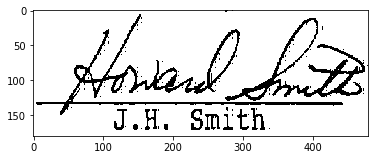

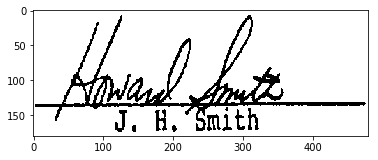

In [14]:
test = train_generator.__getitem__(1)
plt.imshow(test[0][0][2][:,:,0], cmap='gray')
plt.figure()
plt.imshow(test[0][1][2][:,:,0], cmap='gray')

## Visualizing a negative example

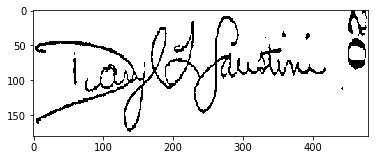

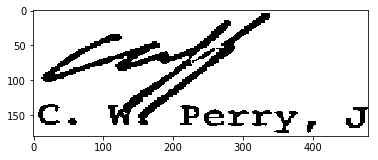

In [25]:
plt.imshow(test[0][0][1][:,:,0], cmap='gray')
plt.figure()
plt.imshow(test[0][1][1][:,:,0], cmap='gray')

## Building the model

In [8]:
def l2_distance(tensors):
    x = tensors[0]
    y = tensors[1]
    distance = tf.sqrt(tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True))
    return distance

def conv_block(x, n_filters, size, strides=1):
    x = tf.keras.layers.Conv2D(filters=n_filters,
               kernel_size=size,
               padding='same',
               strides=strides,
               kernel_initializer='he_normal',
               use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def residual_block(x, n_filters):
    skip = x
    x = conv_block(x, n_filters//2, 1)
    x = conv_block(x, n_filters, 3)
    x = tf.keras.layers.add([x, skip])
    return x

def base_model(H=180, W=480):
    input_layer = tf.keras.layers.Input(shape=(H, W, 1))
    x = conv_block(input_layer, 32, 3)
    x = conv_block(x, 64, 3, strides=2)
    x = residual_block(x, 64)
    x = conv_block(x, 128, 3, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = conv_block(x, 256, 3, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    output_layer = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='base_model')
    return model   

In [9]:
base = base_model()

right_image = tf.keras.layers.Input(shape=(180, 480, 1), name='right_image')
left_image = tf.keras.layers.Input(shape=(180, 480, 1), name='left_image')

right_out = base(right_image)
left_out = base(left_image)

y = tf.keras.layers.Lambda(l2_distance, name='l2_distance')([right_out, left_out])
model = tf.keras.Model(inputs=[right_image, left_image], outputs=y)
model.load_weights('signature_weights.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
right_image (InputLayer)        (None, 180, 480, 1)  0                                            
__________________________________________________________________________________________________
left_image (InputLayer)         (None, 180, 480, 1)  0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 256)          1892384     right_image[0][0]                
                                                                 left_image[0][0]                 
__________________________________________________________________________________________________
l2_distance (Lambda)            (None

## Defining the loss function and accuracy metric

In [11]:
def contrastive_loss(y_true, y_pred, m=1):
    return (y_true) * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(0., m - y_pred))

def accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, dtype=tf.float32)), dtype=tf.float32))

## Training the model

In [12]:
p_model = tf.keras.utils.multi_gpu_model(model, 3)
p_model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics=[accuracy])
p_model.fit_generator(train_generator, epochs=10, workers=128, max_queue_size=500, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
554/554 [==============================] - 319s 576ms/step - loss: 0.2032 - accuracy: 0.7477
Epoch 2/10
554/554 [==============================] - 323s 584ms/step - loss: 0.1593 - accuracy: 0.7921
Epoch 3/10
554/554 [==============================] - 323s 583ms/step - loss: 0.1545 - accuracy: 0.7996
Epoch 4/10
554/554 [==============================] - 328s 593ms/step - loss: 0.1488 - accuracy: 0.8107
Epoch 5/10
554/554 [==============================] - 333s 601ms/step - loss: 0.1469 - accuracy: 0.8181
Epoch 6/10
554/554 [==============================] - 349s 630ms/step - loss: 0.1407 - accuracy: 0.8263
Epoch 7/10
554/554 [==============================] - 337s 608ms/step - loss: 0.1413 - accuracy: 0.8262
Epoch 8/10
554/554 [==============================] - 325s 587ms/step - loss: 0.1388 - accuracy: 0.8305
Epoch 9/10
554/554 [==============================] - 336s 606ms/step - loss: 0.1373 - accuracy: 0.8333
Epoch 10/10
554/

## Save the trained model weights

In [13]:
model.save_weights('signature_weights.h5')